## CS310 Natural Language Processing
## Assignment 3. Recurrent Neural Networks for Language Modeling 

**Total points**: 

In this assignment, you will train a vanilla RNN-based language model on the Harry Potter text data. 

### 0. Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
import random

# 下载必要的NLTK数据
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
# 在第一个代码单元格的导入语句之后添加：

# 设置GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"  # 指定使用GPU 4-7

# 检查CUDA是否可用
print(f"CUDA是否可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"当前使用的GPU设备: {os.environ['CUDA_VISIBLE_DEVICES']}")
    print(f"可用的GPU数量: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("警告：没有检测到可用的GPU！")

# 设置默认设备
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用的设备: {DEVICE}")

# 确保模型和数据都在GPU上
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

[nltk_data] Downloading package punkt to /home/hljiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hljiang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/hljiang/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/hljiang/nltk_data...
[nltk_data]   Package words is already up-to-date!


CUDA是否可用: True
当前使用的GPU设备: 4,5,6,7
可用的GPU数量: 4
GPU 0: NVIDIA GeForce RTX 4090 D
GPU 1: NVIDIA GeForce RTX 4090 D
GPU 2: NVIDIA GeForce RTX 4090 D
GPU 3: NVIDIA GeForce RTX 4090 D
使用的设备: cuda


In [2]:
#Data Processing
class Vocabulary:
    def __init__(self, min_freq=2):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<BOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<BOS>', 3: '<EOS>'}
        self.min_freq = min_freq
        
    def build_vocab(self, text):
        # 统计词频
        word_counts = Counter(text)
        # 只保留频率大于min_freq的词
        valid_words = [word for word, count in word_counts.items() if count >= self.min_freq]
        
        # 构建词典
        for word in valid_words:
            if word not in self.word2idx:
                self.word2idx[word] = len(self.word2idx)
                self.idx2word[len(self.idx2word)] = word
                
    def __len__(self):
        return len(self.word2idx)

class TextDataset(Dataset):
    def __init__(self, text, vocab, seq_length):
        self.vocab = vocab
        self.seq_length = seq_length
        
        # 将文本转换为索引
        self.data = [self.vocab.word2idx.get(word, self.vocab.word2idx['<UNK>']) 
                    for word in text]
        
        # 创建序列
        self.sequences = []
        for i in range(0, len(self.data) - seq_length, 1):
            seq = self.data[i:i + seq_length]
            target = self.data[i + 1:i + seq_length + 1]
            self.sequences.append((seq, target))
            
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq, target = self.sequences[idx]
        return torch.LongTensor(seq), torch.LongTensor(target)

# 加载和预处理数据
def load_and_preprocess_data(file_path, seq_length=35):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    
    # 使用简单的空格分词
    words = text.split()
    
    # 构建词汇表
    vocab = Vocabulary(min_freq=2)
    vocab.build_vocab(words)
    
    # 修改为90%-5%的训练测试集划分
    train_size = int(len(words) * 0.9)
    test_size = int(len(words) * 0.05)
    
    train_words = words[:train_size]
    test_words = words[train_size:train_size + test_size]
    
    # 创建数据集
    train_dataset = TextDataset(train_words, vocab, seq_length)
    test_dataset = TextDataset(test_words, vocab, seq_length)
    
    return train_dataset, test_dataset, vocab



### 1. Build the Model

In [3]:
### 2. Model Implementation

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.5):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, 
                         batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
    def forward(self, x, hidden=None):
        # x shape: [batch_size, seq_len]
        batch_size = x.size(0)
        
        if hidden is None:
            hidden = self.init_hidden(batch_size)
            
        # 词嵌入
        embedded = self.dropout(self.embedding(x))
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        # RNN前向传播
        output, hidden = self.rnn(embedded, hidden)
        # output shape: [batch_size, seq_len, hidden_dim]
        
        # 应用dropout
        output = self.dropout(output)
        
        # 全连接层
        output = self.fc(output)
        # output shape: [batch_size, seq_len, vocab_size]
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)


### 2. Train and Evaluate

Epoch [1/10], Step [100/956], Loss: 6.7860
Epoch [1/10], Step [200/956], Loss: 6.0436
Epoch [1/10], Step [300/956], Loss: 5.8688
Epoch [1/10], Step [400/956], Loss: 5.7776
Epoch [1/10], Step [500/956], Loss: 5.7256
Epoch [1/10], Step [600/956], Loss: 5.6859
Epoch [1/10], Step [700/956], Loss: 5.6571
Epoch [1/10], Step [800/956], Loss: 5.6364
Epoch [1/10], Step [900/956], Loss: 5.6236
Epoch [1/10], Test Perplexity: 407.1824
Epoch [2/10], Step [100/956], Loss: 5.5989
Epoch [2/10], Step [200/956], Loss: 5.5963
Epoch [2/10], Step [300/956], Loss: 5.5918
Epoch [2/10], Step [400/956], Loss: 5.5832
Epoch [2/10], Step [500/956], Loss: 5.5846
Epoch [2/10], Step [600/956], Loss: 5.5925
Epoch [2/10], Step [700/956], Loss: 5.5895
Epoch [2/10], Step [800/956], Loss: 5.5970
Epoch [2/10], Step [900/956], Loss: 5.6071
Epoch [2/10], Test Perplexity: 435.6928
Epoch [3/10], Step [100/956], Loss: 5.6250
Epoch [3/10], Step [200/956], Loss: 5.6370
Epoch [3/10], Step [300/956], Loss: 5.6695
Epoch [3/10], Ste

/tmp/ipykernel_3021331/1687166586.py:173: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3021331/1687166586.py:173: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3021331/1687166586.py:173: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3021331/1687166586.py:173: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3021331/1687166586.py:173: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3021331/1687166586.py:173: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3021331/1687166586.py:173: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from

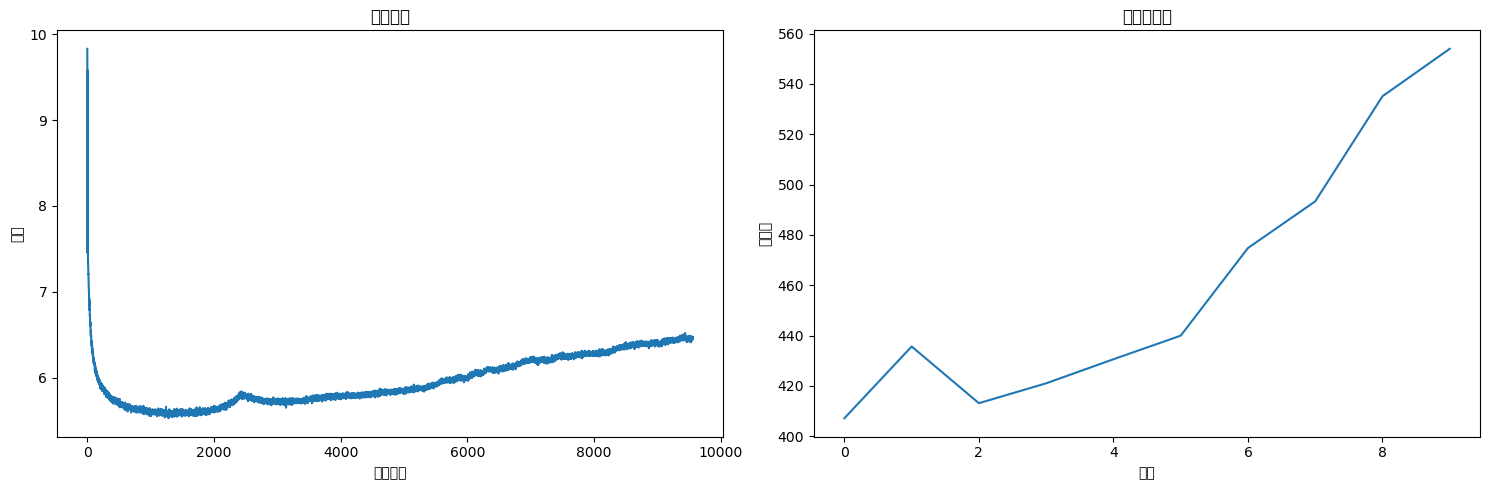

In [4]:
### 3. Training and Evaluation Functions
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"  # 指定使用GPU 4-7

def train_model(model, train_loader, test_loader, criterion, optimizer, 
                num_epochs, device, print_every=100):
    model.train()  # 确保模型处于训练模式
    train_losses = []
    test_perplexities = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        batch_losses = []  # 用于存储每个batch的损失
        
        for i, (inputs, targets) in enumerate(train_loader):
            # 获取当前batch的大小
            batch_size = inputs.size(0)
            
            # 初始化隐藏状态
            hidden = model.init_hidden(batch_size).to(device)
            
            # 将数据移到设备上
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs, hidden = model(inputs, hidden)
            hidden = hidden.detach()  # 分离计算图
            
            # 计算损失
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
            # 记录损失
            total_loss += loss.item()
            batch_losses.append(loss.item())  # 存储每个batch的损失
            train_losses.append(loss.item())  # 存储所有训练步骤的损失
            
            if (i + 1) % print_every == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '\
                      f'Loss: {total_loss/print_every:.4f}')
                total_loss = 0
        
        # 计算测试集困惑度
        model.eval()  # 切换到评估模式
        test_perplexity = evaluate(model, test_loader, criterion, device)
        test_perplexities.append(test_perplexity)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Perplexity: {test_perplexity:.4f}')
        
        # 切换回训练模式
        model.train()
        
    return train_losses, test_perplexities

def evaluate(model, test_loader, criterion, device):
    model.eval()  # 确保模型处于评估模式
    total_loss = 0
    with torch.no_grad():  # 禁用梯度计算
        for inputs, targets in test_loader:
            # 获取当前batch的大小
            batch_size = inputs.size(0)
            
            # 初始化隐藏状态
            hidden = model.init_hidden(batch_size).to(device)
            
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            total_loss += loss.item() * inputs.size(0)
    
    avg_loss = total_loss / len(test_loader.dataset)
    perplexity = np.exp(avg_loss)
    return perplexity

def generate_text(model, vocab, prefix, max_length=50, temperature=1.0):
    model.eval()
    words = prefix.lower().split()
    
    with torch.no_grad():
        # 初始化隐藏状态
        hidden = model.init_hidden(1).to(DEVICE)  # batch_size=1 for generation
        
        for i in range(max_length):
            curr_seq = torch.LongTensor([[vocab.word2idx.get(w, vocab.word2idx['<UNK>']) 
                                        for w in words[-1:]]]).to(DEVICE)
            
            output, hidden = model(curr_seq, hidden)
            output_dist = output.div(temperature).exp()
            top_idx = torch.multinomial(output_dist.view(-1), 1)[0]
            
            predicted_word = vocab.idx2word[top_idx.item()]
            words.append(predicted_word)
            
            if predicted_word == '<EOS>':
                break
    
    return ' '.join(words)

### 4. Main Training Loop

# 设置参数
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
NUM_LAYERS = 2
BATCH_SIZE = 1024
NUM_EPOCHS = 10
LEARNING_RATE = 0.01
SEQUENCE_LENGTH = 35
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载数据
file_path = '/home/hljiang/CS310-Natural_Language_Processing/assignments/A3/Harry_Potter_all_books_preprocessed.txt'
train_dataset, test_dataset, vocab = load_and_preprocess_data(file_path, SEQUENCE_LENGTH)

# 创建数据加载器
train_loader = DataLoader(train_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True,
                         num_workers=4)  # 增加数据加载的并行度
test_loader = DataLoader(test_dataset, 
                        batch_size=BATCH_SIZE,
                        num_workers=4)

# 初始化模型
model = RNNModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 训练模型并获取损失历史
train_losses, test_perplexities = train_model(model, train_loader, test_loader, 
                                            criterion, optimizer, NUM_EPOCHS, DEVICE)

# 生成示例文本
test_prefixes = [
    "Harry looked at",
    "The castle was",
    "Hermione said",
    "Ron couldn't",
    "Dumbledore smiled"
]

print("\nGenerated Text Samples:")
for prefix in test_prefixes:
    generated = generate_text(model, vocab, prefix)
    print(f"\nPrefix: {prefix}")
    print(f"Generated: {generated}")



# 绘制训练损失和测试困惑度曲线
plt.figure(figsize=(15, 5))

# 绘制训练损失
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('训练损失')
plt.xlabel('训练步数')
plt.ylabel('损失')

# 绘制测试困惑度
plt.subplot(1, 2, 2)
plt.plot(test_perplexities)
plt.title('测试困惑度')
plt.xlabel('轮次')
plt.ylabel('困惑度')

plt.tight_layout()
plt.show()